In [1]:
import tensorflow as tf
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
import sys
print(sys.version)

3.10.11 | packaged by Anaconda, Inc. | (main, May 16 2023, 00:55:32) [MSC v.1916 64 bit (AMD64)]


In [3]:
import os
import numpy as np
import pandas
import cv2
import matplotlib.pyplot as plt
import csv
import random
from skimage.transform import rotate
import joblib
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split

## Set class names

In [4]:
class_names = {
    0: "Speed limit (20km/h)", 1: "Speed limit (30km/h)", 2: "Speed limit (50km/h)",
    3: "Speed limit (60km/h)", 4: "Speed limit (70km/h)", 5: "Speed limit (80km/h)",
    6: "End of speed limit (80km/h)", 7: "Speed limit (100km/h)", 8: "Speed limit (120km/h)",
    9: "No passing", 10: "No passing for vehicles over 3.5 metric tons",
    11: "Right-of-way at the next intersection", 12: "Priority road", 13: "Yield",
    14: "Stop", 15: "No vehicles", 16: "Vehicles over 3.5 metric tons prohibited",
    17: "No entry", 18: "General caution", 19: "Dangerous curve to the left",
    20: "Dangerous curve to the right", 21: "Double curve", 22: "Bumpy road",
    23: "Slippery road", 24: "Road narrows on the right", 25: "Road work",
    26: "Traffic signals", 27: "Pedestrians", 28: "Children crossing",
    29: "Bicycles crossing", 30: "Beware of ice/snow", 31: "Wild animals crossing",
    32: "End of all speed and passing limits", 33: "Turn right ahead",
    34: "Turn left ahead", 35: "Ahead only", 36: "Go straight or right",
    37: "Go straight or left", 38: "Keep right", 39: "Keep left",
    40: "Roundabout mandatory", 41: "End of no passing",
    42: "End of no passing for vehicles over 3.5 metric tons"
}

## Load images for NN

In [5]:
#Courtesy of GTSRB website

# function for reading the images
# arguments: path to the traffic sign data, for example './GTSRB/Training'
# returns: list of images, list of corresponding labels 
def readTrafficSigns(rootpath):
    '''Reads traffic sign data for German Traffic Sign Recognition Benchmark.

    Arguments: path to the traffic sign data, for example './GTSRB/Training'
    Returns:   list of images, list of corresponding labels'''
    images = [] # images
    labels = [] # corresponding labels
    # loop over all 42 classes
    for c in range(0,43):
        prefix = rootpath + '/' + format(c, '05d') + '/' # subdirectory for class
        gtFile = open(prefix + 'GT-'+ format(c, '05d') + '.csv') # annotations file
        gtReader = csv.reader(gtFile, delimiter=';') # csv parser for annotations file
        next(gtReader)  # skip header 
        # loop over all images in current annotations file
        for row in gtReader:
            images.append(plt.imread(prefix + row[0])) # the 1th column is the filename
            labels.append(row[7]) # the 8th column is the label
        gtFile.close()
    return images, labels


I,L = readTrafficSigns("E:\\Semester2\\Machine Learning\\GTSRB_Data\\Final_Training\\images")

In [6]:
print("Total images:", len(I))
print("Total labels:", len(L))
if(len(I)==len(L)):
    print("No mismatches detected")

Total images: 39209
Total labels: 39209
No mismatches detected


In [7]:
def augment_with_rotation(images, labels, rotation_range=(-15, 15), n=1): #Creates n altered copies of each image, start with 1 for now
    augmented_images = []
    augmented_labels = []
    
    for image, label in zip(images, labels):
        augmented_images.append(image)
        augmented_labels.append(label)
        
        for _ in range(n):
            angle = random.uniform(rotation_range[0], rotation_range[1])
            rotated = rotate(image, angle, mode='edge')  #helps with border artifacts
            augmented_images.append((rotated * 255).astype(np.uint8))  # Convert back to 0-255 range
            augmented_labels.append(label)
    
    return augmented_images, augmented_labels
augmented_I, augmented_L = augment_with_rotation(I, L, rotation_range=(-10, 10), n=1)

In [8]:
print(f"Original dataset size: {len(I)}")
print(f"Augmented dataset size: {len(augmented_I)}")

Original dataset size: 39209
Augmented dataset size: 78418


In [9]:
#resize to 48x48
augmented_I = [cv2.resize(img, (48, 48)) for img in augmented_I]

In [10]:
#augmented_I_Gray = np.array([cv2.cvtColor(img, cv2.COLOR_RGB2GRAY) for img in augmented_I_RGB])
augmented_I = np.array(augmented_I)
augmented_I_RGB = []
augmented_I_Gray = []

for img in augmented_I:
    #Convert to grayscale (from BGR as thats what cv2 uses)
    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    augmented_I_Gray.append(gray_img)
    augmented_I_RGB.append(img)  

augmented_I_RGB = np.array(augmented_I_RGB)  # Shape: (N, 48, 48, 3) in BGR
augmented_I_Gray = np.array(augmented_I_Gray)  # Shape: (N, 48, 48)

#Labels remain unchanged
print(f"RGB images shape: {augmented_I_RGB.shape}")
print(f"Grayscale images shape: {augmented_I_Gray.shape}")
print(f"Labels count: {len(augmented_L)}")  # Should match N

RGB images shape: (78418, 48, 48, 3)
Grayscale images shape: (78418, 48, 48)
Labels count: 78418


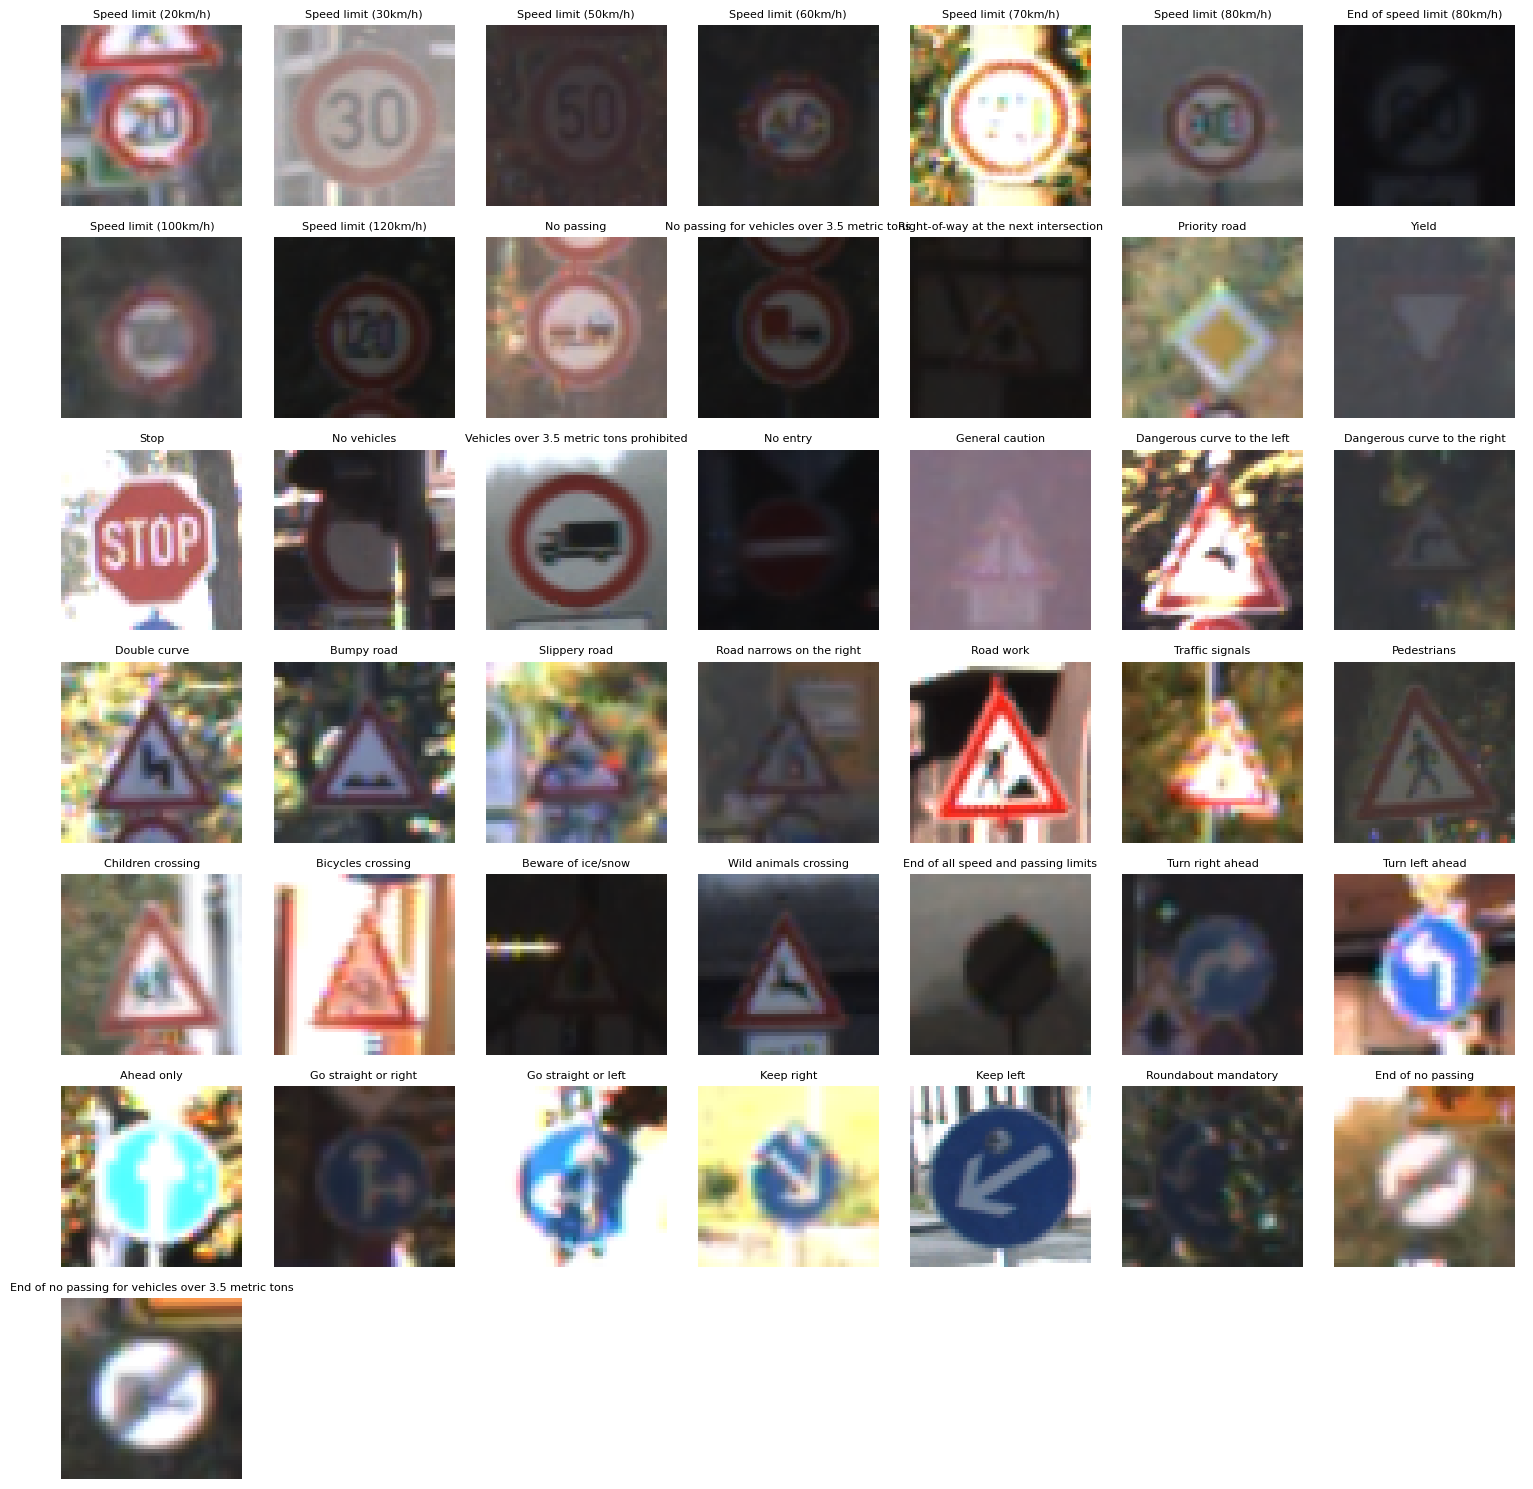

In [11]:
images_per_class = {}

#Loop through the list of labels and images (I, L) 
for image, label in zip(augmented_I_RGB, augmented_L):
                                        #Stores the first image in each class
    if label not in images_per_class:
        images_per_class[label] = image

fig, axes = plt.subplots(7, 7, figsize=(15, 15))  
axes = axes.flatten()  

#Loop through the images_per_class dictionary and plot the images
for idx, (label, image) in enumerate(images_per_class.items()):
    axes[idx].imshow(image) 
    axes[idx].set_title(class_names[int(label)], fontsize=8)  
    axes[idx].axis('off')  

for i in range(len(images_per_class), len(axes)):
    axes[i].axis('off')

plt.tight_layout() 
plt.show()

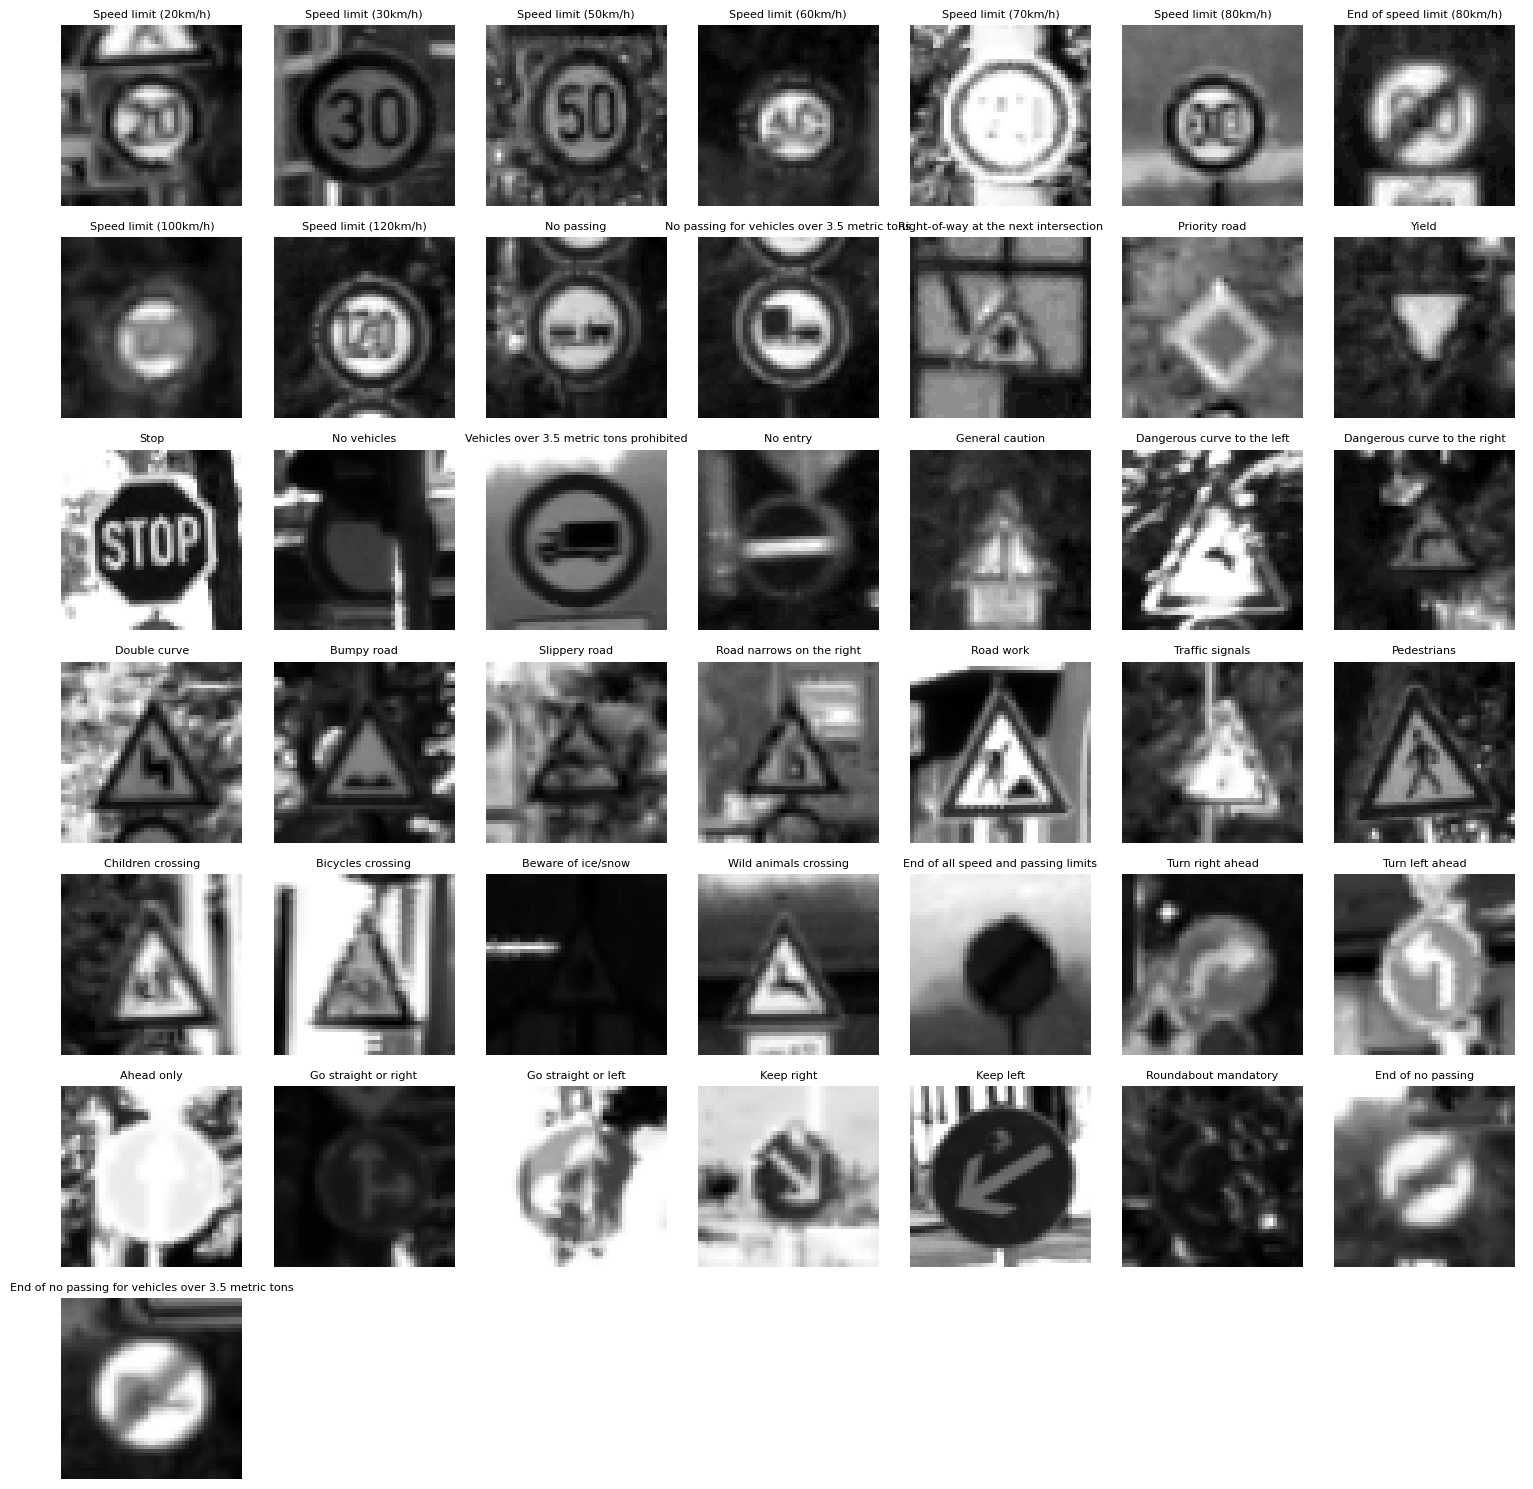

In [12]:
images_per_class = {}

#Loop through the list of labels and images (I, L) 
for image, label in zip(augmented_I_Gray, augmented_L):
                                        #Stores the first image in each class
    if label not in images_per_class:
        images_per_class[label] = image

fig, axes = plt.subplots(7, 7, figsize=(15, 15))  
axes = axes.flatten()  

#Loop through the images_per_class dictionary and plot the images
for idx, (label, image) in enumerate(images_per_class.items()):
    axes[idx].imshow(image,cmap="gray") 
    axes[idx].set_title(class_names[int(label)], fontsize=8)  
    axes[idx].axis('off')  

for i in range(len(images_per_class), len(axes)):
    axes[i].axis('off')

plt.tight_layout() 
plt.show()

## NN

In [34]:
from tensorflow.keras import layers, models, Input
from tensorflow.keras.utils import to_categorical

In [35]:
X = augmented_I_RGB
y = augmented_L  
print(len(X),len(y))

78418 78418


In [36]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42,stratify=y)

In [37]:
#Convert string labels to integers and then to one-hot encoding
y_train_int = np.array(y_train).astype(int)
y_train_onehot = to_categorical(y_train_int, num_classes=43)

#pixel values to [0, 1]
X_train = X_train.astype('float32') / 255.0

#Create multiple columns
def create_branch(input_shape=(48, 48, 3)):
    inputs = Input(shape=input_shape)
    #Layer 1: Conv 7x7, 100 maps of 42×42
    x = layers.Conv2D(100, (7, 7), activation='relu')(inputs)
    #Layer 2: MaxPool 2x2, 100 maps of 21×21
    x = layers.MaxPooling2D((2, 2))(x)
    #Layer 3: Conv 4x4, 150 maps of 18×18
    x = layers.Conv2D(150, (4, 4), activation='relu')(x)
    #Layer 4: MaxPool 2x2 , 150 maps of 9×9
    x = layers.MaxPooling2D((2, 2))(x)
    #Layer 5: Conv 4x4, 250 maps of 6×6
    x = layers.Conv2D(250, (4, 4), activation='relu')(x)
    #Layer 6: MaxPool 2x2 ,250 maps of 3×3
    x = layers.MaxPooling2D((2, 2))(x)
    #Flatten
    x = layers.Flatten()(x)
    
    return inputs, x

#Create n many branches
num_branches = 3
branch_inputs = []
branch_outputs = []
for _ in range(num_branches):
    inp, out = create_branch()
    branch_inputs.append(inp)
    branch_outputs.append(out)
#combine our branches
merged = layers.concatenate(branch_outputs)

#conected layers
#Layer 7: Fully connected 300 neurons
x = layers.Dense(300, activation='relu')(merged)
x = layers.Dropout(0.5)(x)  #dropout for regularization

#layer 8 - output (43)
outputs = layers.Dense(43, activation='softmax')(x)

#Create model
model = models.Model(inputs=branch_inputs, outputs=outputs)

#compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

#input data - duplicate for each branch
X_train_multi = [X_train] * num_branches

#Train
history = model.fit(X_train_multi, y_train_onehot,
                    epochs=10,
                    batch_size=32,
                    validation_split=0.2)

#View model architecture
model.summary()

Epoch 1/10
1569/1569 [==============================] - 32s 20ms/step - loss: 0.8387 - accuracy: 0.7592 - val_loss: 0.0771 - val_accuracy: 0.9802
Epoch 2/10
1569/1569 [==============================] - 32s 20ms/step - loss: 0.1166 - accuracy: 0.9658 - val_loss: 0.0407 - val_accuracy: 0.9880
Epoch 3/10
1569/1569 [==============================] - 32s 20ms/step - loss: 0.0716 - accuracy: 0.9786 - val_loss: 0.0247 - val_accuracy: 0.9931
Epoch 4/10
1569/1569 [==============================] - 32s 20ms/step - loss: 0.0591 - accuracy: 0.9827 - val_loss: 0.0207 - val_accuracy: 0.9947
Epoch 5/10
1569/1569 [==============================] - 31s 20ms/step - loss: 0.0499 - accuracy: 0.9860 - val_loss: 0.0146 - val_accuracy: 0.9965
Epoch 6/10
1569/1569 [==============================] - 31s 19ms/step - loss: 0.0424 - accuracy: 0.9881 - val_loss: 0.0184 - val_accuracy: 0.9952
Epoch 7/10
1569/1569 [==============================] - 31s 20ms/step - loss: 0.0386 - accuracy: 0.9897 - val_loss: 0.0170 -

## Evaluation

1961/1961 [==============================] - 11s 5ms/step
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       336
           1       1.00      1.00      1.00      3552
           2       1.00      1.00      1.00      3600
           3       1.00      1.00      1.00      2256
           4       1.00      1.00      1.00      3168
           5       1.00      1.00      1.00      2976
           6       1.00      1.00      1.00       672
           7       1.00      1.00      1.00      2304
           8       1.00      0.99      1.00      2256
           9       1.00      1.00      1.00      2352
          10       1.00      1.00      1.00      3216
          11       1.00      1.00      1.00      2112
          12       1.00      1.00      1.00      3360
          13       1.00      1.00      1.00      3456
          14       1.00      1.00      1.00      1248
          15       1.00      1.00      1.00      1008


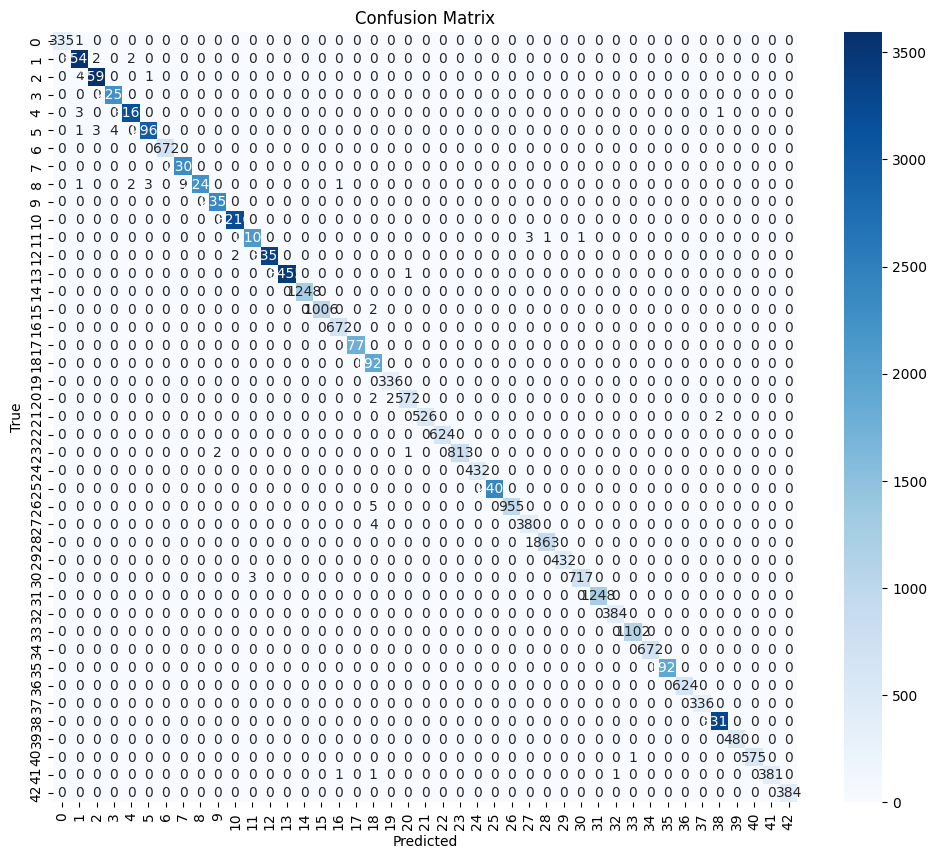

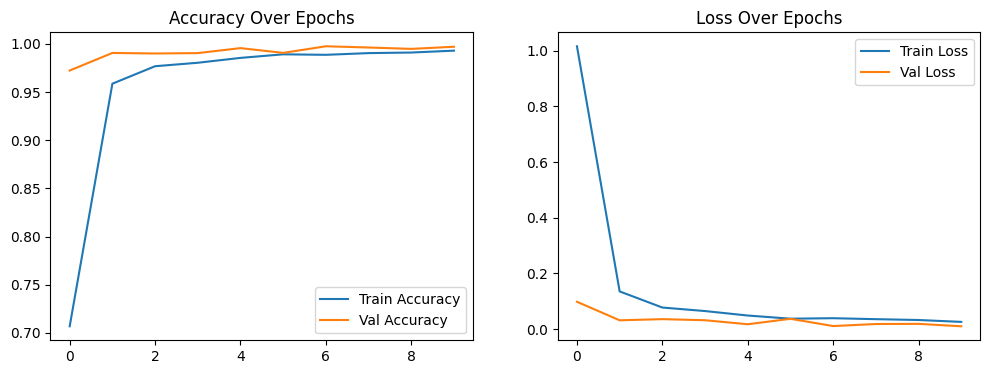

Overall Precision: 0.9988
Overall Recall: 0.9988
Overall F1-Score: 0.9988


In [16]:
#Evaluation metrics
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

#Generate predictions
X_train_multi = [X_train] * num_branches  #Creates list of n identical arrays, 1 input but suitable for n many columns

#Now evaluate
y_pred = model.predict(X_train_multi) 
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_train_onehot, axis=1)

#Classification report
print("Classification Report:")
print(classification_report(y_true, y_pred_classes, target_names=[str(i) for i in range(43)]))

#Confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(12,10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

#Accuracy and loss plots
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title("Accuracy Over Epochs")
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("Loss Over Epochs")
plt.legend()
plt.show()

#Additional metrics
from sklearn.metrics import precision_score, recall_score, f1_score
print(f"Overall Precision: {precision_score(y_true, y_pred_classes, average='weighted'):.4f}")
print(f"Overall Recall: {recall_score(y_true, y_pred_classes, average='weighted'):.4f}")
print(f"Overall F1-Score: {f1_score(y_true, y_pred_classes, average='weighted'):.4f}")

In [25]:
#10 wrong examples

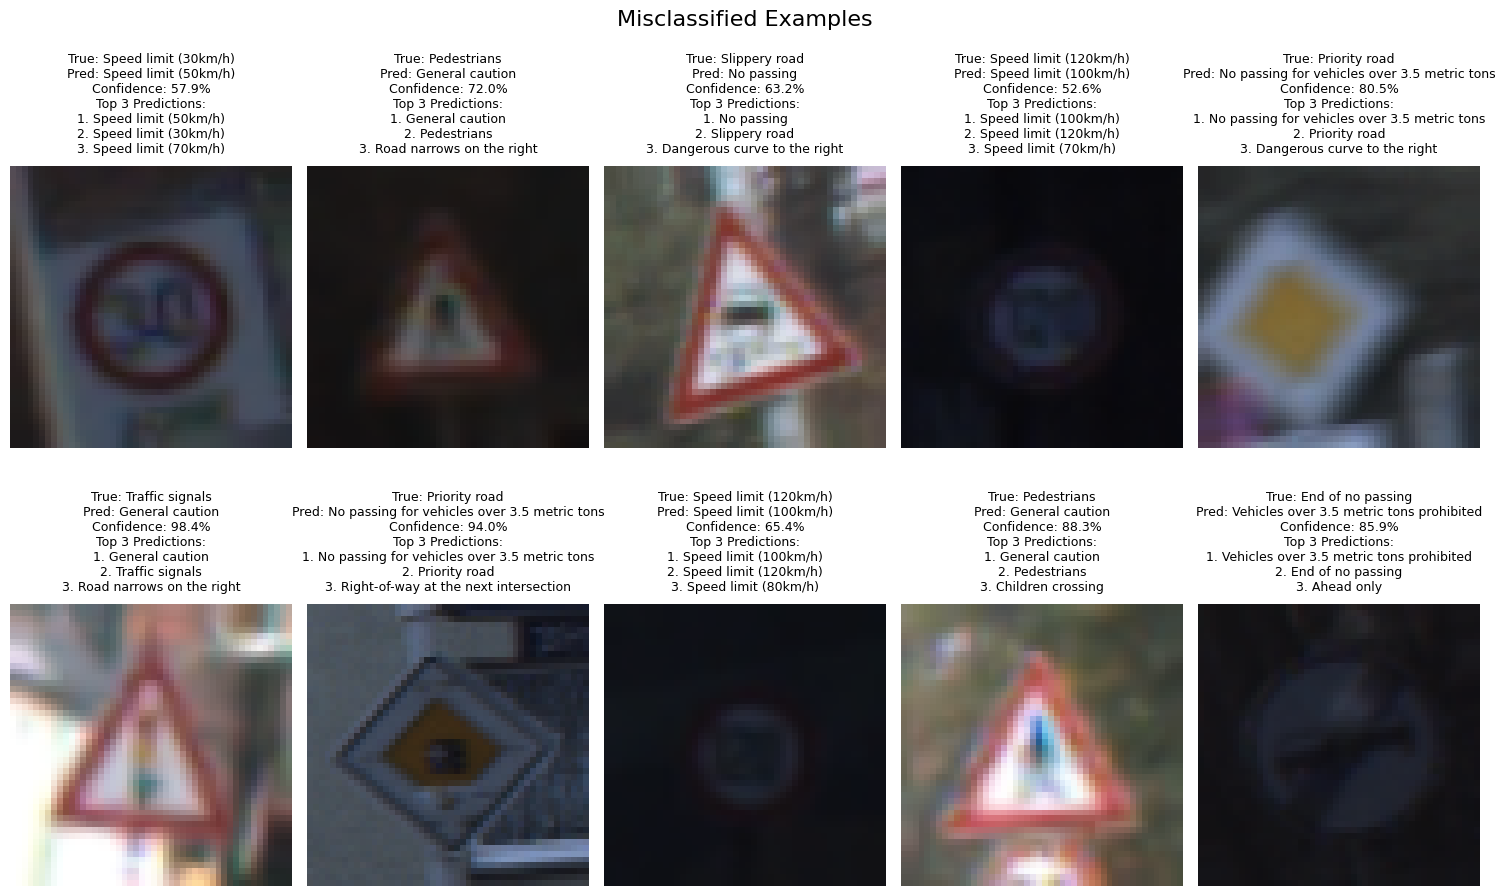

In [24]:
#misclassified examples
wrong_indices = np.where(y_pred_classes != y_true)[0]
np.random.shuffle(wrong_indices)  # Randomize which errors we show

plt.figure(figsize=(15,10))
plt.suptitle("Misclassified Examples", fontsize=16)

for i, idx in enumerate(wrong_indices[:10]):
    plt.subplot(2, 5, i+1)
    
    # Display image (handling both normalized and unnormalized)
    img = (X_train[idx] * 255).astype('uint8') if X_train[idx].max() <= 1 else X_train[idx]
    plt.imshow(img)
    
    #Get prediction info
    true_class = y_true[idx]
    pred_class = y_pred_classes[idx]
    confidence = np.max(y_pred[idx])
    top3_probs = np.argsort(y_pred[idx])[-3:][::-1]
    
    # Create descriptive label
    label_text = (f"True: {class_names[true_class]}\n"
                 f"Pred: {class_names[pred_class]}\n"
                 f"Confidence: {confidence:.1%}\n"
                 f"Top 3 Predictions:\n"
                 f"1. {class_names[top3_probs[0]]}\n"
                 f"2. {class_names[top3_probs[1]]}\n"
                 f"3. {class_names[top3_probs[2]]}")
    
    plt.title(label_text, fontsize=9, pad=10)
    plt.axis('off')

plt.tight_layout()
plt.show()

In [26]:
#20 wrong examples

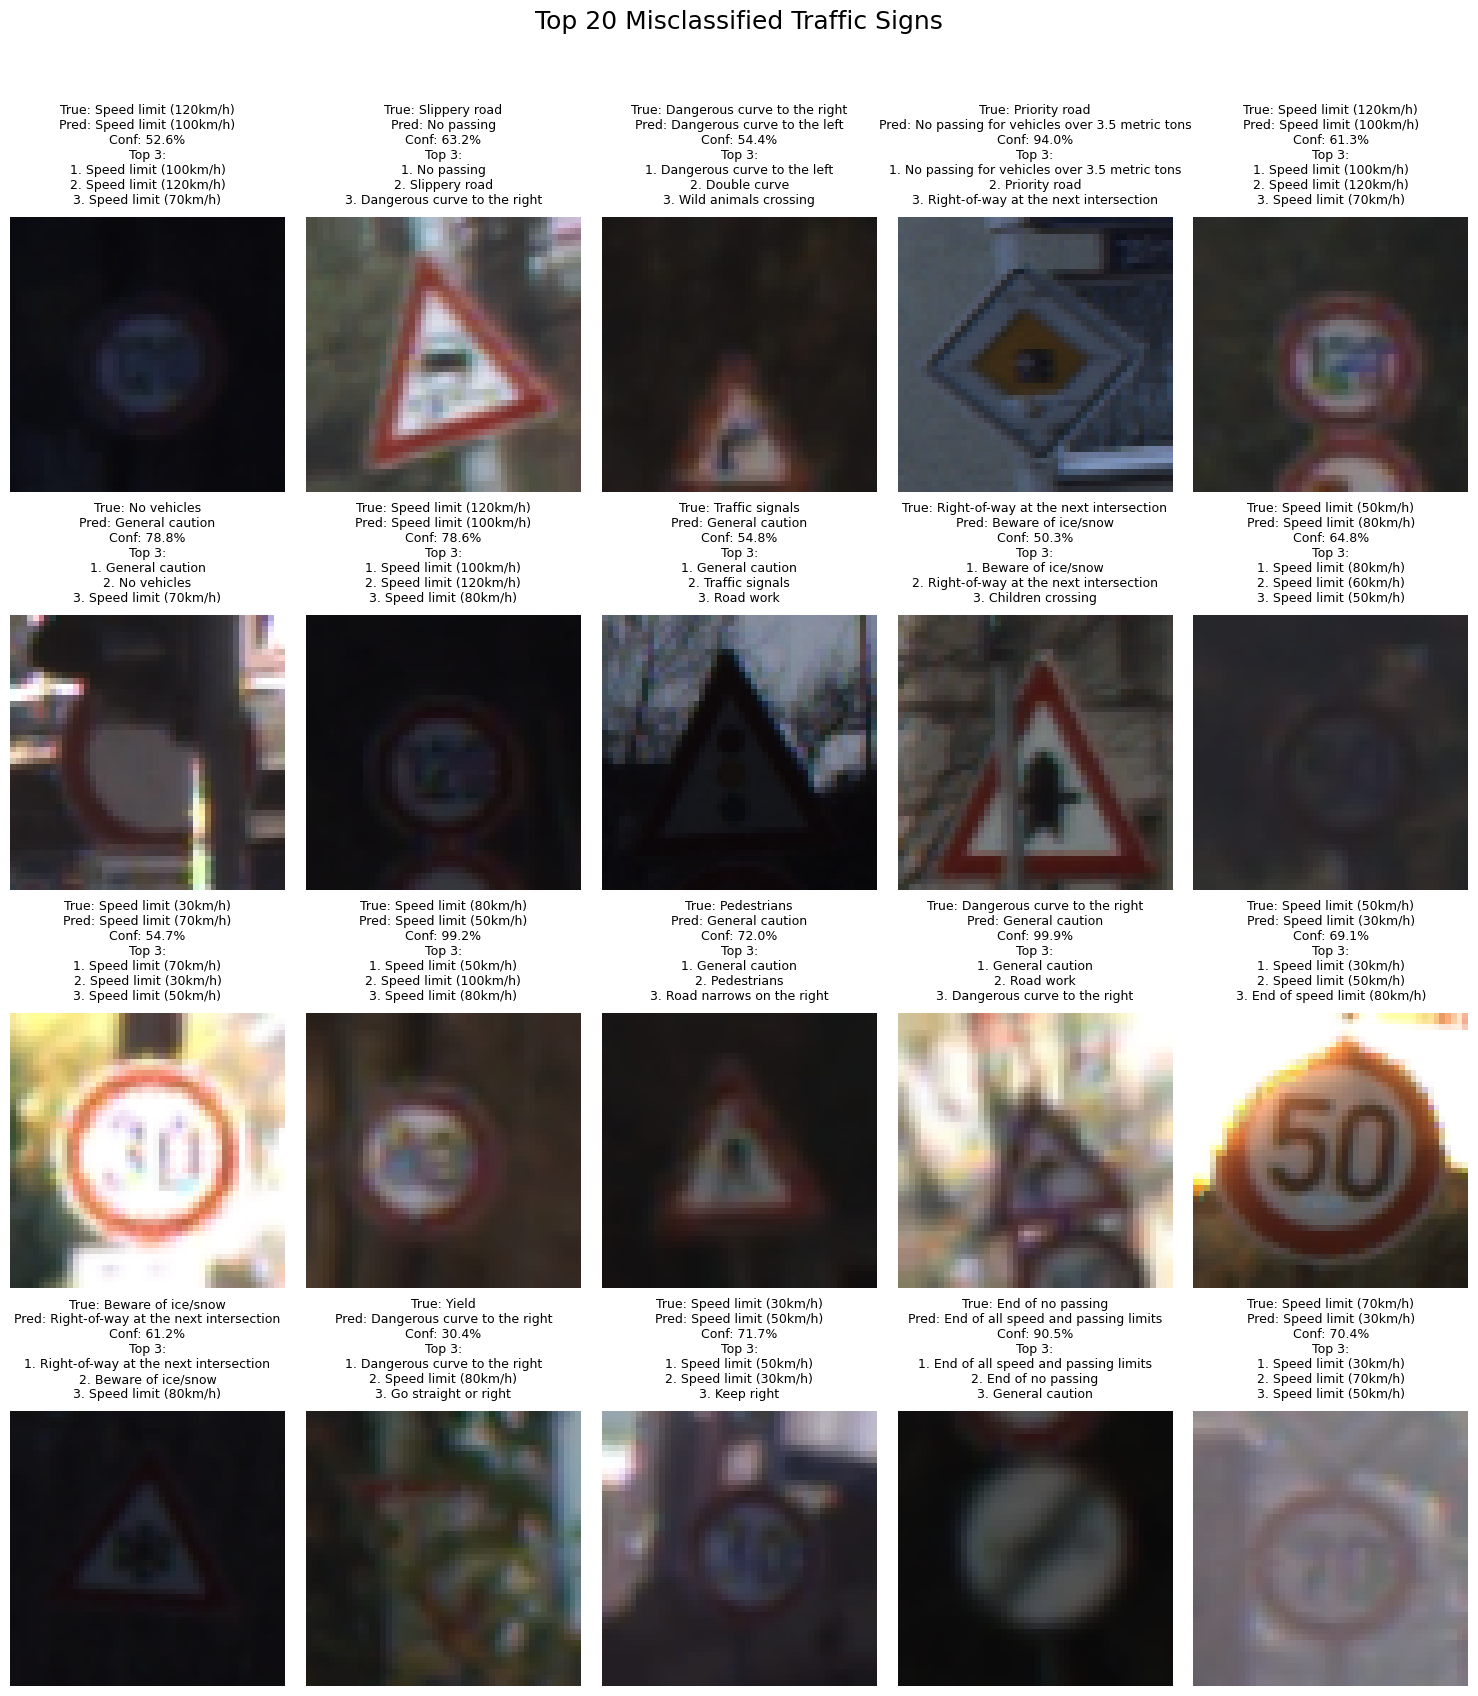

In [32]:
import numpy as np
import matplotlib.pyplot as plt

#Get misclassified examples
wrong_indices = np.where(y_pred_classes != y_true)[0]
np.random.shuffle(wrong_indices)  # Randomize which errors we show

#set up larger figure for 20 examples
plt.figure(figsize=(15, 17))
plt.suptitle("Top 20 Misclassified Traffic Signs", fontsize=18, y=1.02)

#Display 20 wrong predictions in 4 rows of 5
for i, idx in enumerate(wrong_indices[:20]):
    plt.subplot(4, 5, i+1)  #4 rows 5 cols
    
    img = (X_train[idx] * 255).astype('uint8') if X_train[idx].max() <= 1 else X_train[idx]
    plt.imshow(img)
    
    #info
    true_class = y_true[idx]
    pred_class = y_pred_classes[idx]
    confidence = np.max(y_pred[idx])
    top3_probs = np.argsort(y_pred[idx])[-3:][::-1]
    
    #label
    label_text = (f"True: {class_names[true_class]}\n"
                 f"Pred: {class_names[pred_class]}\n"
                 f"Conf: {confidence:.1%}\n"
                 f"Top 3:\n"
                 f"1. {class_names[top3_probs[0]]}\n"
                 f"2. {class_names[top3_probs[1]]}\n"
                 f"3. {class_names[top3_probs[2]]}")
    
    plt.title(label_text, fontsize=9, pad=10)  
    plt.axis('off')

plt.tight_layout(pad=1.5)
plt.show()